In [3]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
from sklearn.decomposition import FastICA

We use ICA to reduce the dimensionality and separate the mixed components. Then we use emcee to estimate the parameter of a sin model and compute the period and its uncertainty

Text(0.5, 1.0, 'Outputs from three detectors')

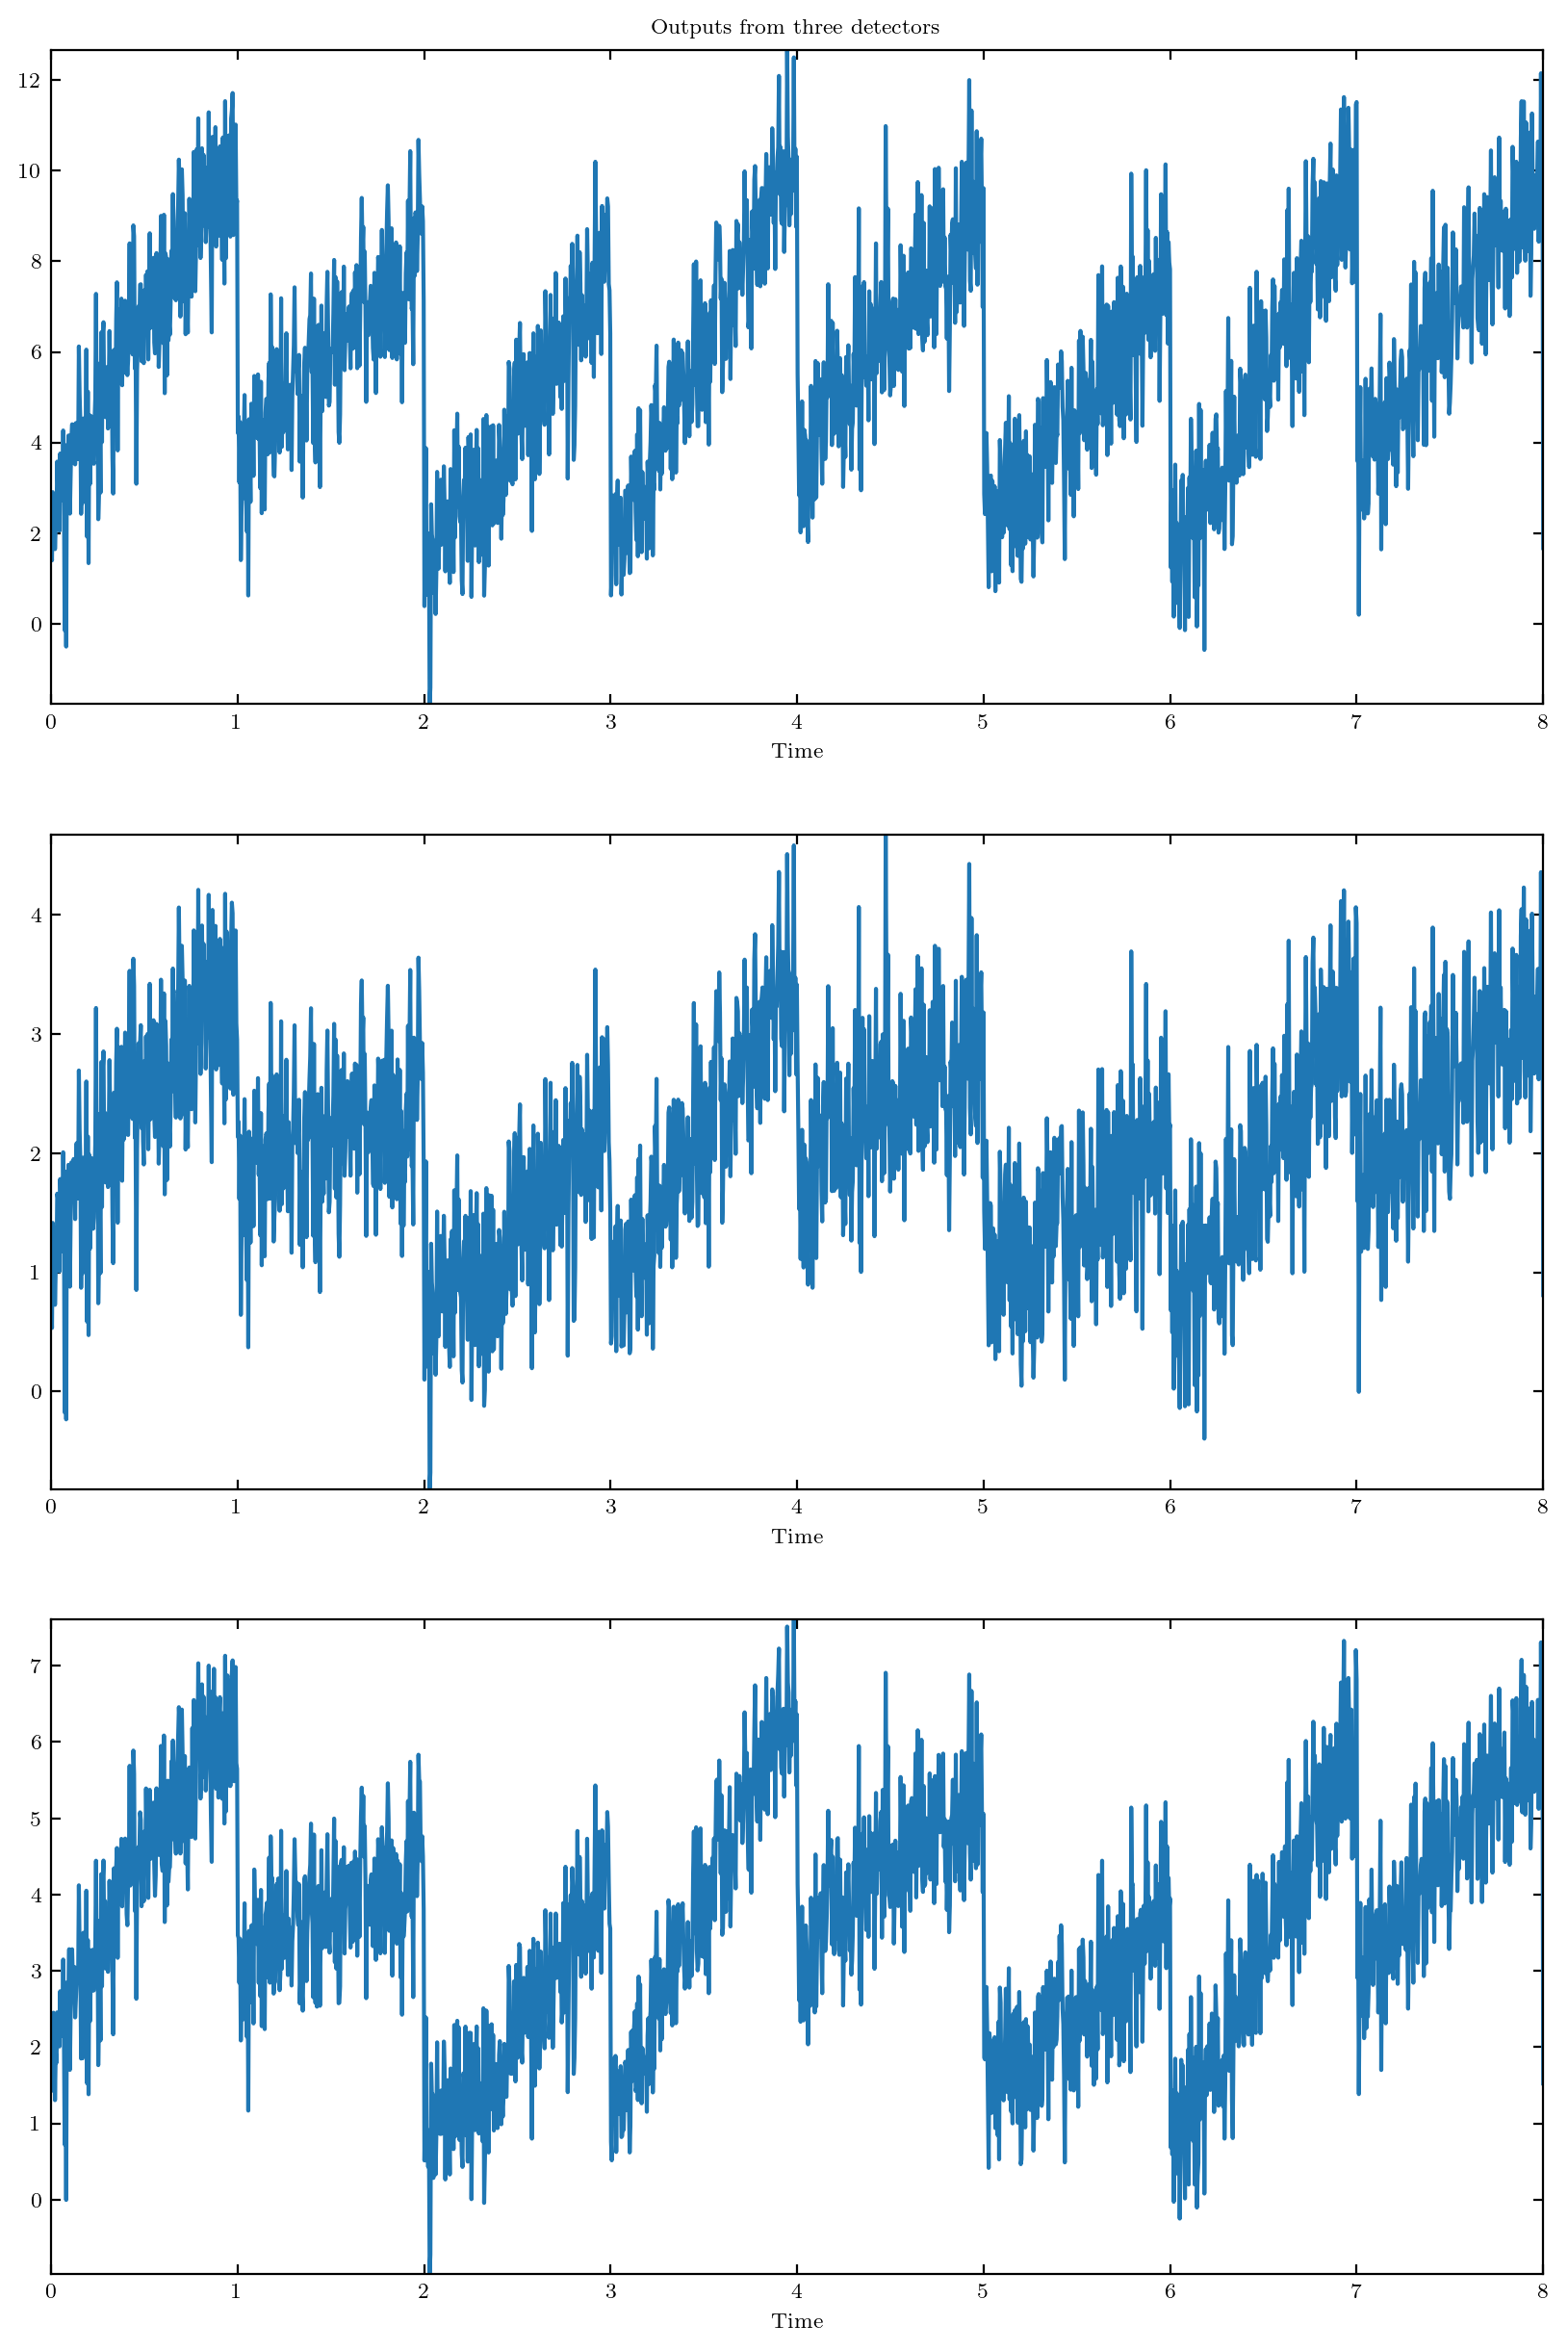

In [14]:
X=np.load('../solutions/noisydetector.npy')

time = np.linspace(0, 8, X.shape[0])

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors')

(3, 3) (2000,) (2000, 3) (2000, 3)


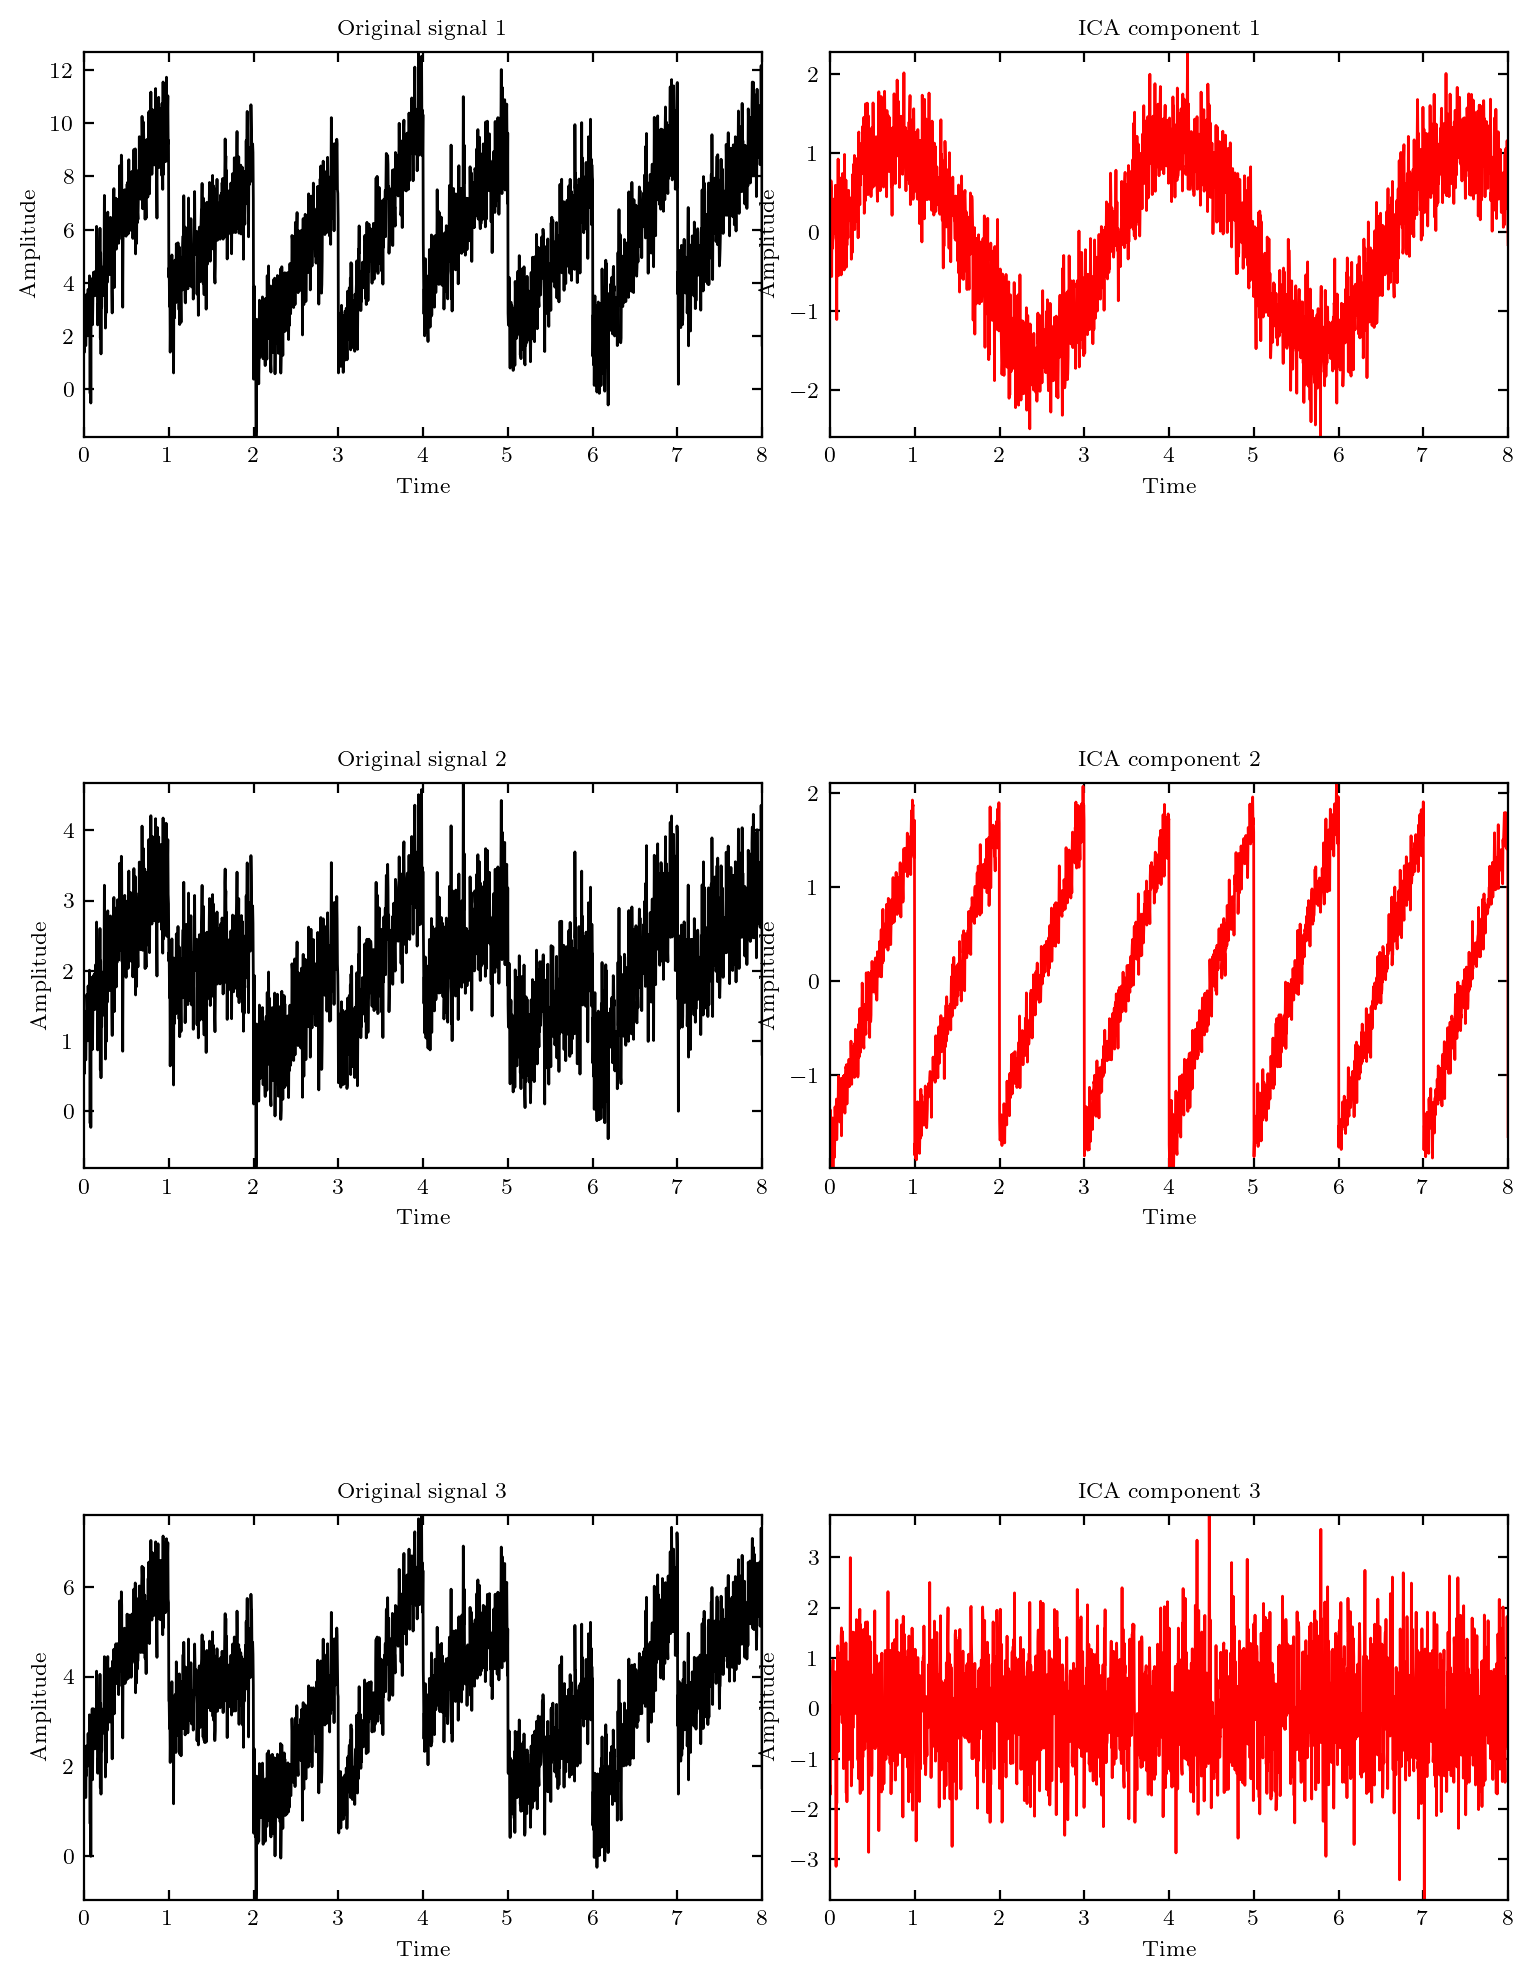

In [ ]:
spec_mean = X.mean(0)
ica = FastICA(n_components=3)
X_ica=ica.fit_transform(X)

fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=0.9, wspace=0.1)

print(ica.components_.shape, time.shape, X.shape, X_ica.shape)
titles = 'ICA components'
n_components = 3

for j in range(n_components):
    ax1 = fig.add_subplot(n_components, 3, 3*j + 1)
    ax1.plot(time, X[:, j], '-k', lw=1)
    ax1.set_xlim(time[0], time[-1])
    ax1.set_title(f'Original signal {j+1}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')



    ax3 = fig.add_subplot(n_components, 3, 3*j + 2)
    ax3.plot(time, X_ica[:, j], '-r', lw=1)
    ax3.set_xlim(time[0], time[-1])
    ax3.set_title(f'ICA component {j+1}')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Amplitude')

In [69]:
def model(time, A, phi, T):
    return A * np.sin(2 * np.pi * time / T + phi)
signal=X_ica[:,0]

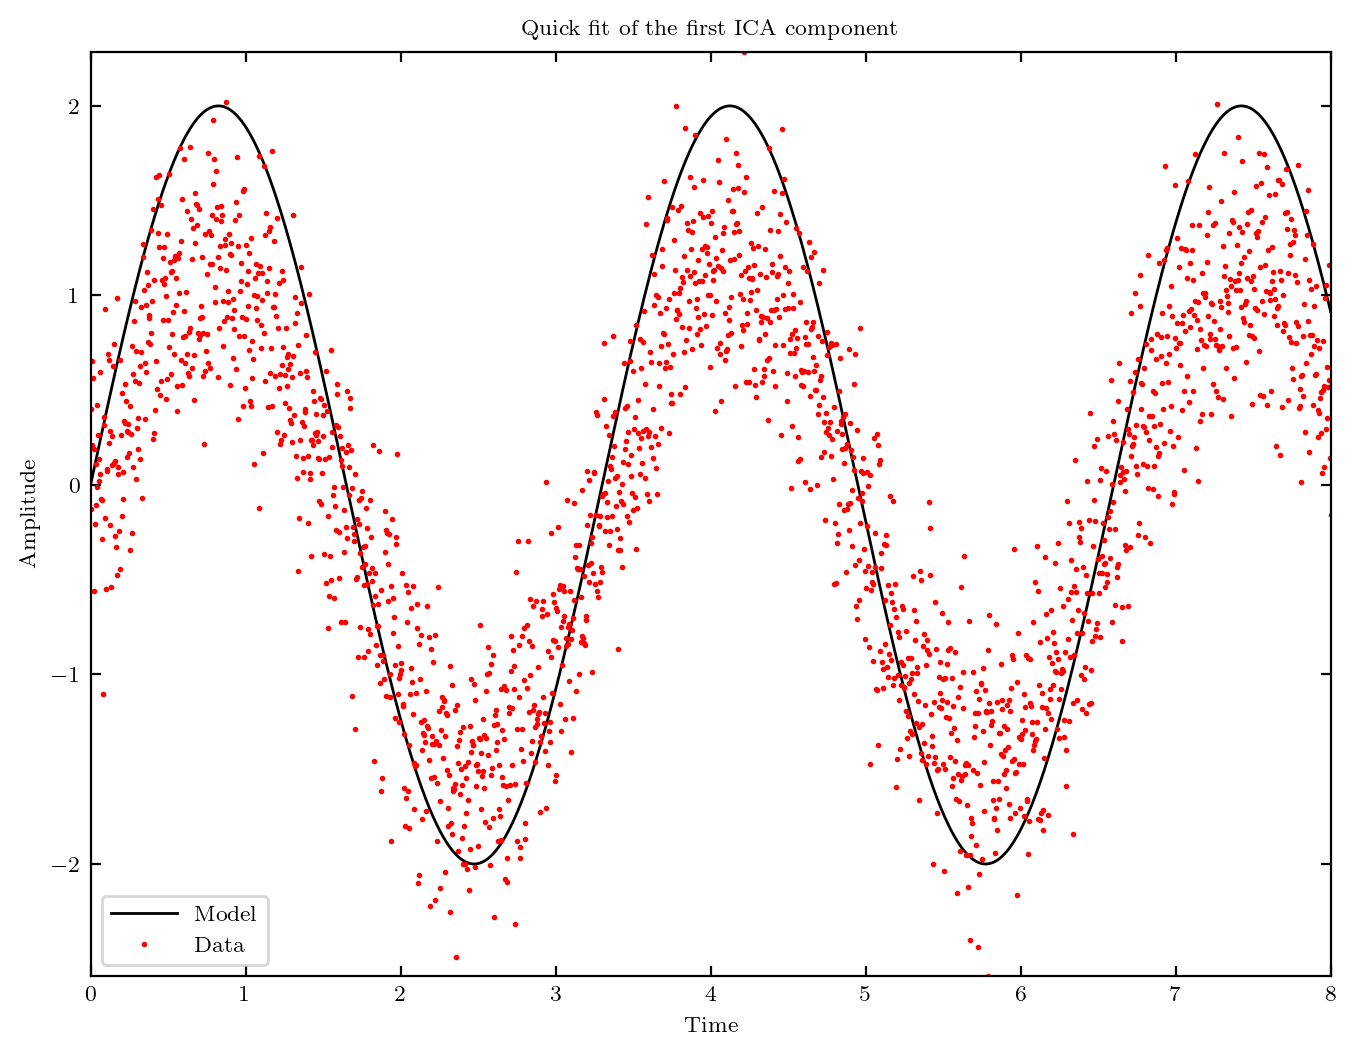

In [54]:
#quick fit
xgrid= np.linspace(0, 8, 1000)
A = 2.0
phi = 0

T = 3.3
ygrid = model(xgrid, A, phi, T)     
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(xgrid, ygrid, 'k-', lw=1, label='Model')
ax.plot(time, X_ica[:, 0], 'r.', ms=2, label='Data')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_title('Quick fit of the first ICA component')
ax.legend() 

100%|██████████| 10000/10000 [00:07<00:00, 1276.60it/s]


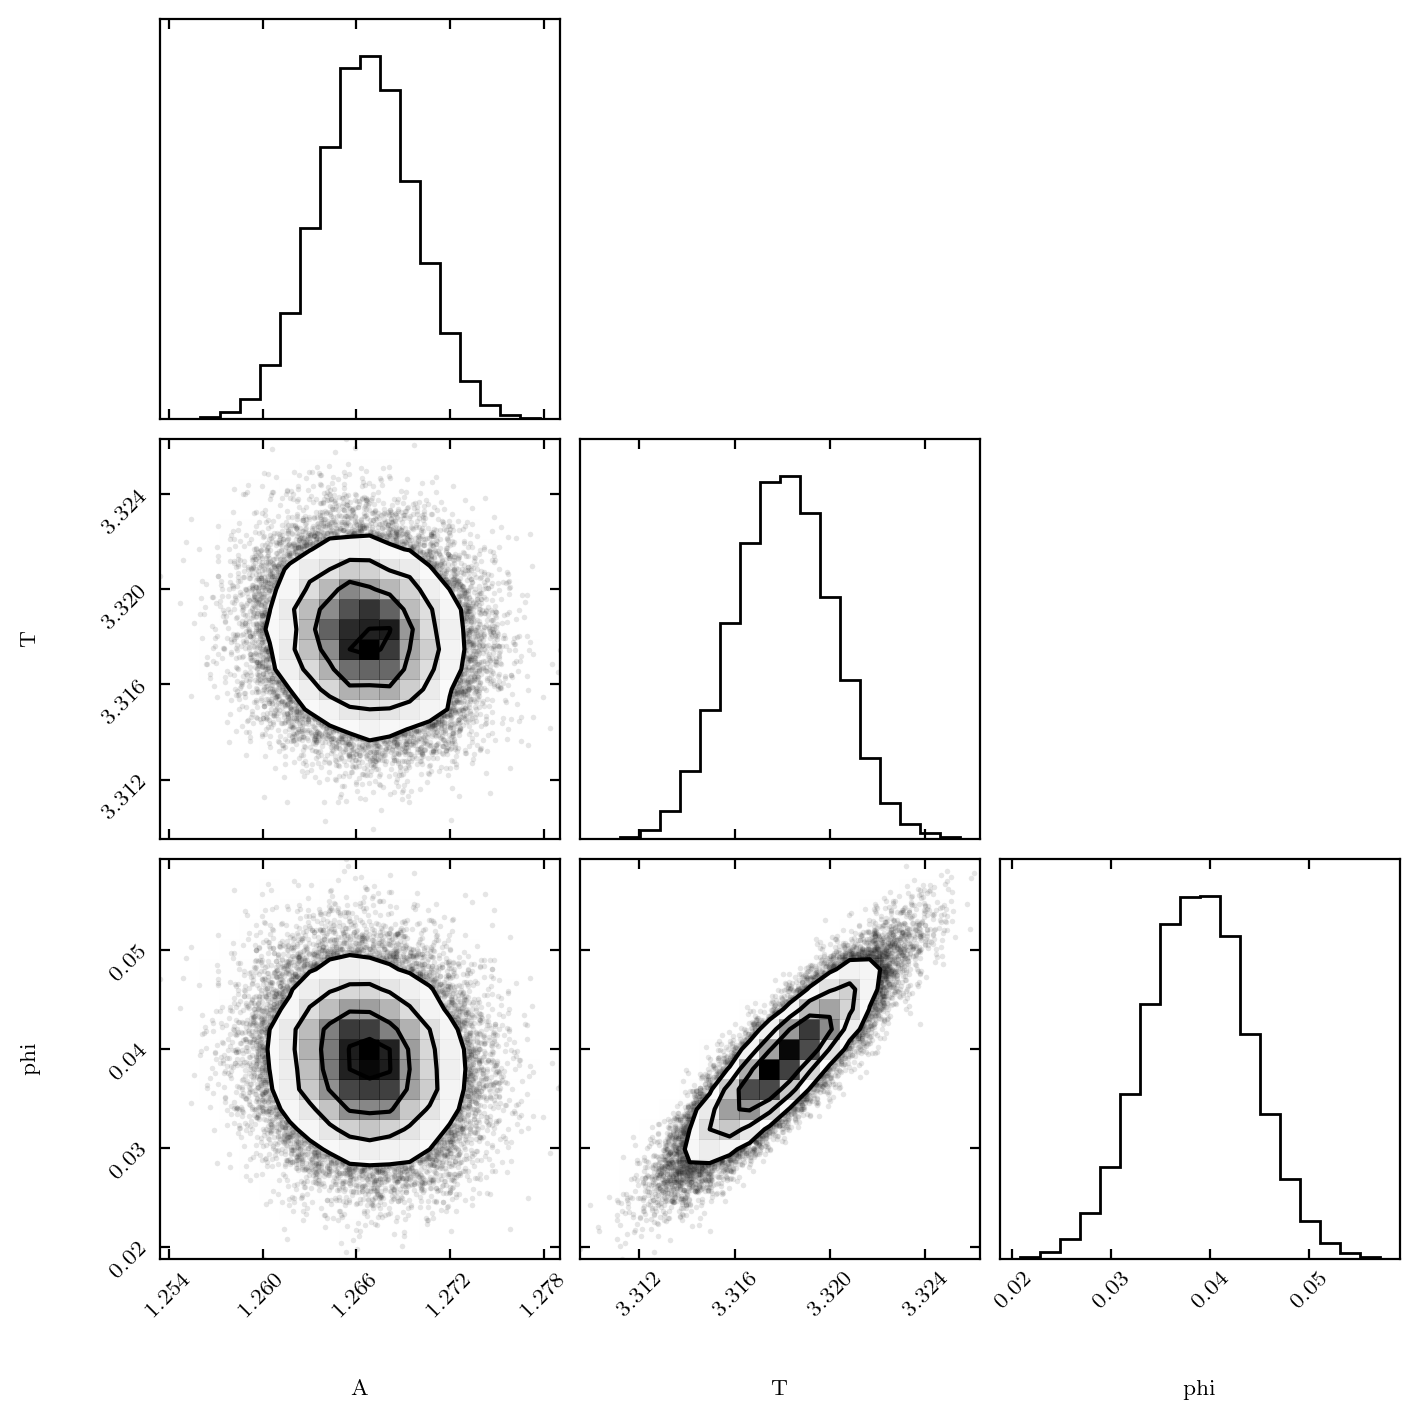

T = 3.3180 (+0.0021 / -0.0021)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner


time = np.linspace(0, 8, X.shape[0])
signal = X_ica[:,0]


def model(t, A, T, phi):
    return A * np.sin(2 * np.pi * t / T + phi)

def log_likelihood(theta, t, y):
    A, T, phi = theta
    model_y = model(t, A, T, phi)
    sigma2 = 0.1**2
    return -0.5 * np.sum((y - model_y)**2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_prior(theta):
    A, T, phi = theta
    if 1 < A < 11 and 1 < T < 8 and -np.pi < phi < np.pi:
        return 0.0
    return -np.inf

def log_probability(theta, t, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y)

ndim = 3
nwalkers = 50

A_guess = 0.5 * (signal.max() - signal.min())
T_guess = 4.0  
phi_guess = 0.0

pos = [ 
    [A_guess, T_guess, phi_guess] + 1e-4 * np.random.randn(ndim) 
    for i in range(nwalkers)
]



sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, signal))
sampler.run_mcmc(pos, 10000, progress=True)

flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

fig = corner.corner(flat_samples, labels=["A", "T", "phi"])
plt.show()

#print the results
T_mcmc = np.percentile(flat_samples[:,1], [16,50,84])
print(f"T = {T_mcmc[1]:.4f} (+{T_mcmc[2]-T_mcmc[1]:.4f} / -{T_mcmc[1]-T_mcmc[0]:.4f})")


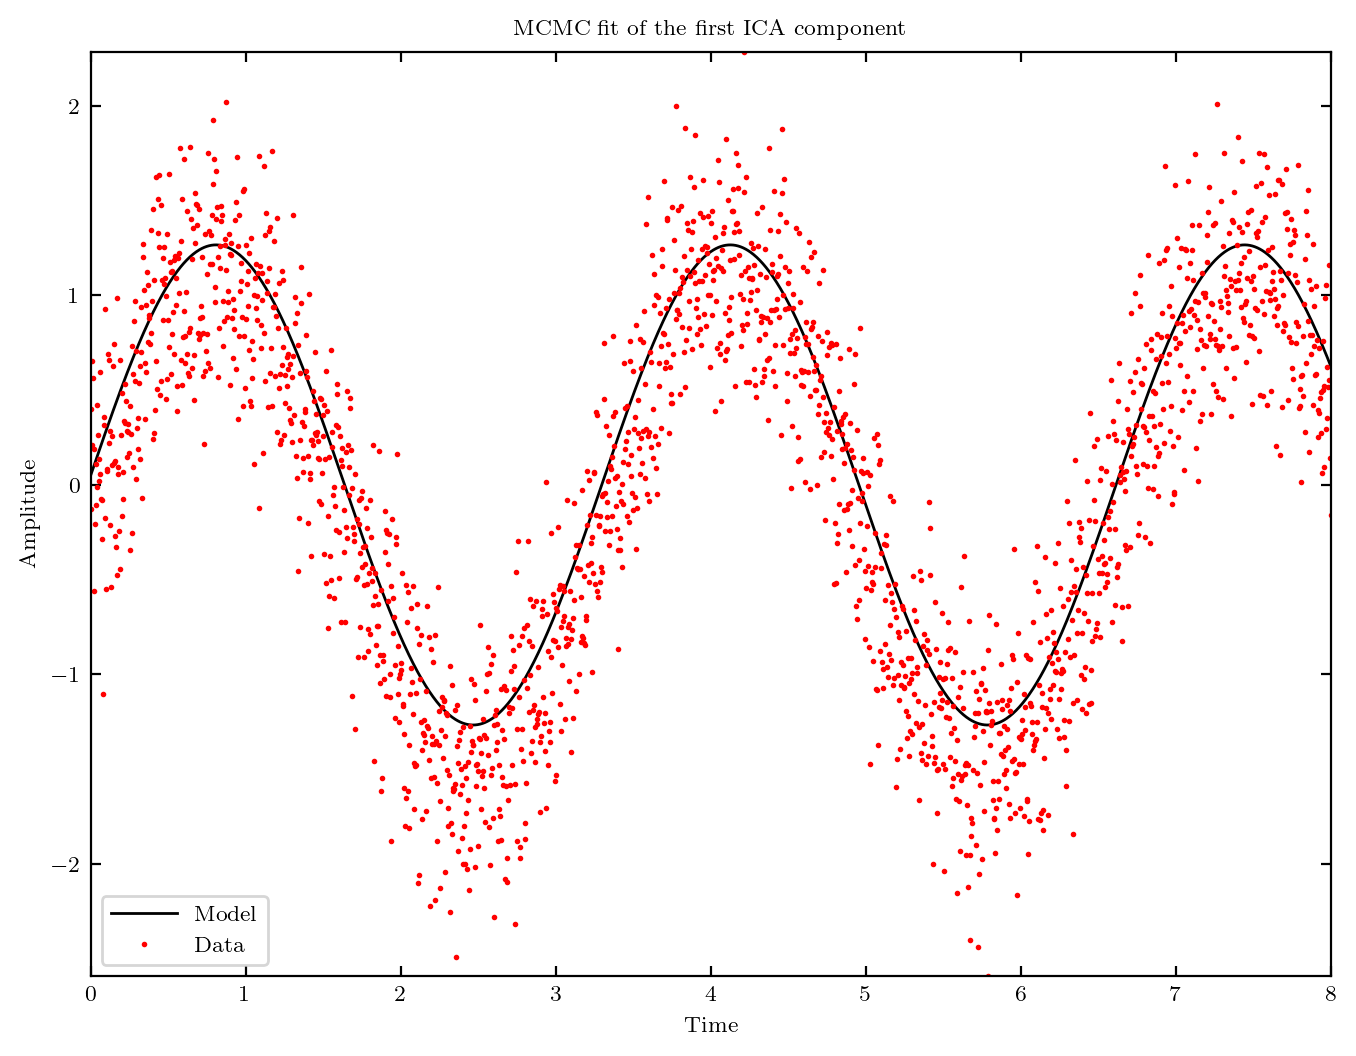

In [81]:
T_median=T_mcmc[1]
A_median = np.percentile(flat_samples[:,0], [50])
phi_median = np.percentile(flat_samples[:,2], [50])
model_median = model(time, A_median, T_median, phi_median)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, model_median, 'k-', lw=1, label='Model')          
ax.plot(time, signal, 'r.', ms=2, label='Data')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_title('MCMC fit of the first ICA component')
ax.legend()